# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
analysis_type = DEFAULT_ANALYSIS  # Analysis type
mouseline = 'pv'  # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # Length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # Evaluation quantile in folling window for baseline evaluation
baseline_smoothing = BASELINE_SMOOTHING   # Whether to smooth the baseline with an extra moving average
ykey_postpro = Label.DFF  # Variable of interest for post-processing

### Derived parameters

In [4]:
# Get batch-related settings
dataset_group_id, trialavg_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, kalman_gain,
    baseline_wlen, baseline_quantile, baseline_smoothing,
    ykey_postpro)

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} {analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 25/10/2022 15:12:32: assembling batch analysis settings...
 25/10/2022 15:12:32: pv main analysis notebook started on 2022-10-25 at 15:12:32


### Input summary table figure

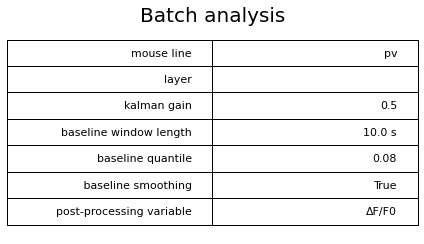

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'baseline window length': f'{baseline_wlen:.1f} s',
    'baseline quantile': baseline_quantile,
    ' baseline smoothing': baseline_smoothing,
    'post-processing variable': ykey_postpro
    }, title='Batch analysis')

### Load data

In [6]:
# Determine exclude patterns
exclude_patterns = None

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop'

# Load datasets
logger.info(f'loading data from {trialavg_dir}:')
data = load_trialavg_datasets(
    trialavg_dir, layer=layer, exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs)

 25/10/2022 15:12:37: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/w10.0s_q0.08_smooth/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/pv:
 25/10/2022 15:12:37: loading trial-averaged data from 20190606_mouse2_region1.h5
 25/10/2022 15:12:37: loading trial-averaged data from 20190606_mouse2_region2.h5
 25/10/2022 15:12:37: loading trial-averaged data from 20190629_mouse2_region1.h5
 25/10/2022 15:12:38: loading trial-averaged data from 20190630_mouse3_region1.h5
 25/10/2022 15:12:38: loading trial-averaged data from 20190702_mouse1_region1.h5
 25/10/2022 15:12:38: loading trial-averaged data from 20190702_mouse5_region1.h5
 25/10/2022 15:12:38: loading trial-averaged data from 20190703_mouse4_region1.h5
 25/10/2022 15:12:38: loading trial-averaged data from 20190821_mouse3_region1.h5
 25/10/2022 15:12:38: loading trial-averaged data from 20190821_mouse6_region1.h5
 25/10/2022 15:12:38: loading trial-averaged data from 2019082

### Breakdown per mouse region, cell maps & filter out datasets

 25/10/2022 15:13:16: extracting timeseries and stats from data...
 25/10/2022 15:13:16: extracting responses types per ROI...
 25/10/2022 15:13:16: plotting cells map color-coded by response type...
 25/10/2022 15:13:17: extracting responses types per ROI...
 25/10/2022 15:13:17: plotting cells map color-coded by response type...
 25/10/2022 15:13:17: extracting responses types per ROI...
 25/10/2022 15:13:17: plotting cells map color-coded by response type...
 25/10/2022 15:13:17: extracting responses types per ROI...
 25/10/2022 15:13:17: plotting cells map color-coded by response type...
 25/10/2022 15:13:17: extracting responses types per ROI...
 25/10/2022 15:13:17: plotting cells map color-coded by response type...
 25/10/2022 15:13:18: extracting responses types per ROI...
 25/10/2022 15:13:18: plotting cells map color-coded by response type...
 25/10/2022 15:13:18: extracting responses types per ROI...
 25/10/2022 15:13:18: plotting cells map color-coded by response type...
 2

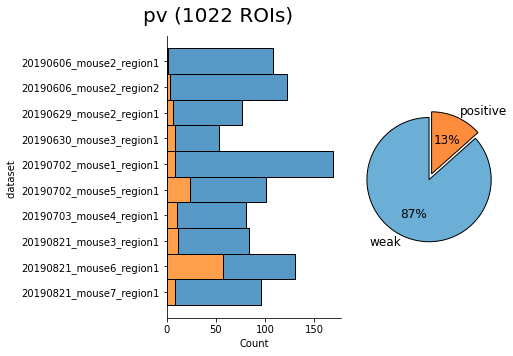

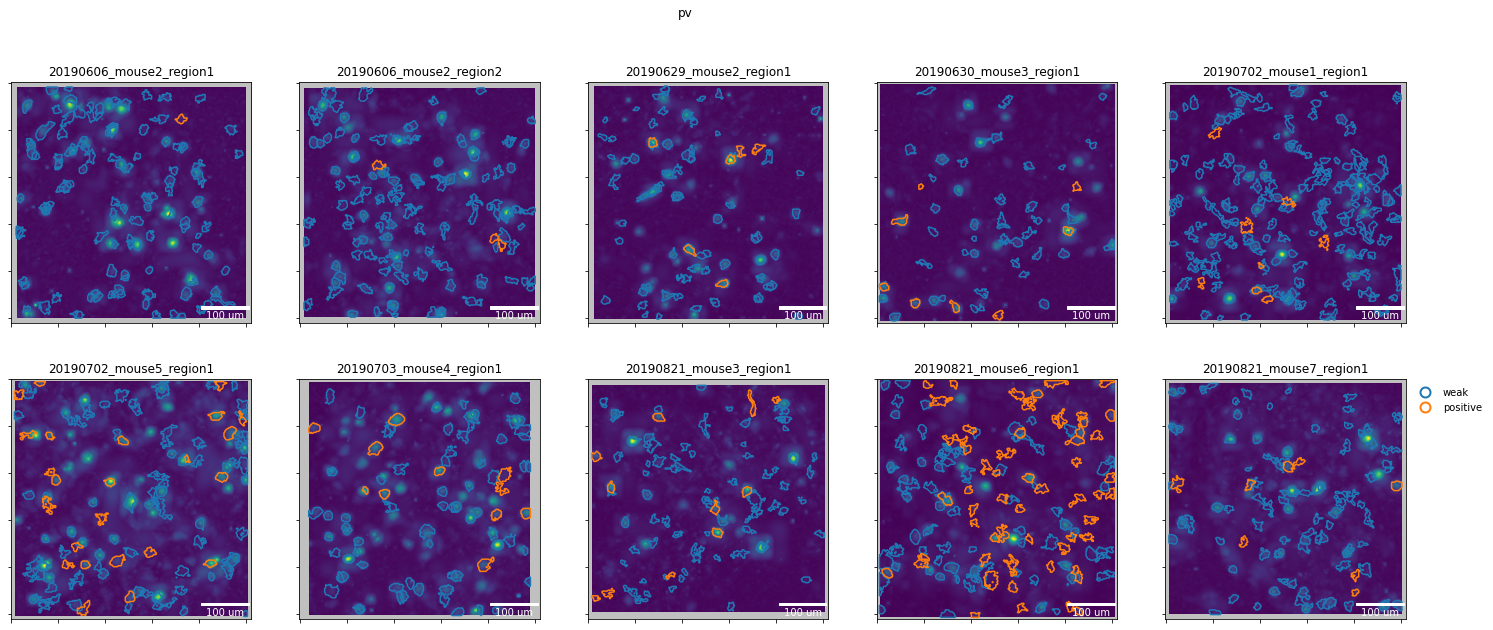

In [7]:
# Extract fields from data
timeseries, stats, ROI_masks, map_ops = extract_from_batch_data(data)
# Plot cell count breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(
    stats, hue=Label.ROI_RESP_TYPE, title=mouseline)
# Plot cell maps
figs['cellmaps'] = plot_cell_maps(
    ROI_masks, stats, map_ops, title=mouseline, refkey='Vcorr', mode='contour')
# Exclude specific datasets
manual_exclude = {
    'line3': [], #'20191109_mouse7_region2'
    'sst': ['20190808_mouse6_region1'],
    'pv': []
}[mouseline]
timeseries, stats = exclude_datasets(timeseries, stats, manual_exclude)

### Plot parameter dependency curves

 25/10/2022 15:13:57: plotting stimulation parameters dependencies for positive responders...
 25/10/2022 15:13:59: plotting stimulation parameters dependencies for weak responders...
 25/10/2022 15:14:01: plotting stimulation parameters dependencies across responders...


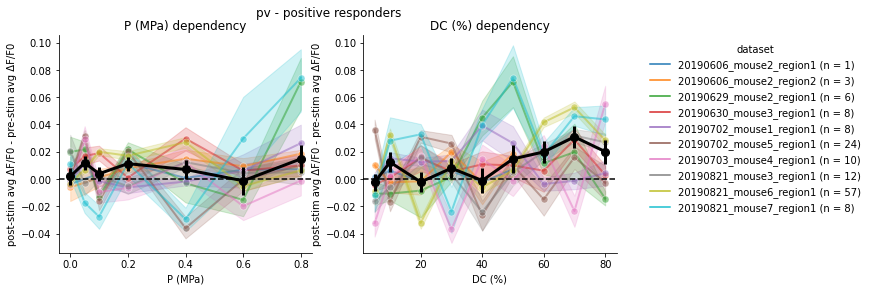

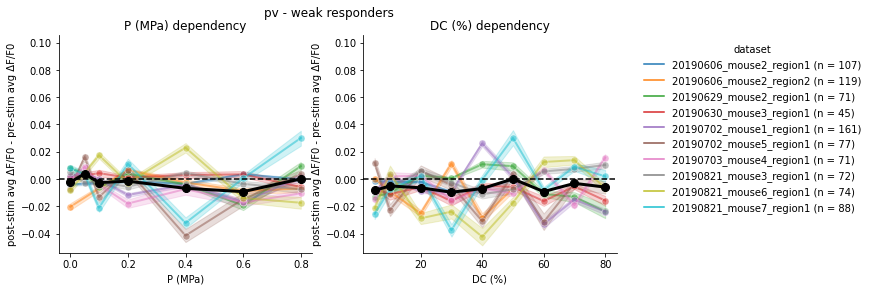

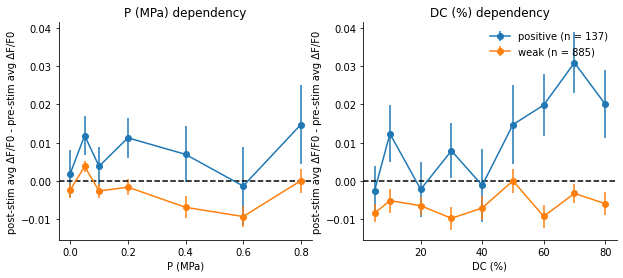

In [8]:
# Determine output metrics key
ykey_diff = get_change_key(ykey_postpro)

# Plot param dependencies across datasets for each responder type separately
tmpaxes = [] 
for rtype, substats in stats.groupby(Label.ROI_RESP_TYPE):
    figkey = f'stimparamdeps_{rtype}'
    logger.info(f'plotting stimulation parameters dependencies for {rtype} responders...')
    logger.setLevel(logging.WARNING)
    figs[figkey] = plot_stimparams_dependency(
        substats, ykey_diff, yref=0, hue=Label.DATASET, avgprop='whue', errprop='intra')
    figs[figkey].suptitle(f'{mouseline} - {rtype} responders')
    tmpaxes = tmpaxes + figs[figkey].axes
    logger.setLevel(logging.INFO)
harmonize_axes_limits(np.asarray(tmpaxes))

# Plot dependencies on each parameter on separate axes
logger.info(f'plotting stimulation parameters dependencies across responders...')
figs['stimparamdeps_global'] = plot_stimparams_dependency(
    stats, hue=Label.ROI_RESP_TYPE, ykey=ykey_diff, yref=0.)

### Plot response traces

 25/10/2022 15:14:30: merging timeseries and stats information...
 25/10/2022 15:14:35: adding time info to table...
 25/10/2022 15:14:36: plotting P (MPa) dependency curves for positive responders...
 25/10/2022 15:14:36: sub-indexing data...
 25/10/2022 15:14:36: filtering data...
 25/10/2022 15:14:36: cross-checking filters...
 25/10/2022 15:14:36: grouping by dataset, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 25/10/2022 15:14:38: plotting P (MPa) dependency curves for weak responders...
 25/10/2022 15:14:38: sub-indexing data...
 25/10/2022 15:14:38: filtering data...
 25/10/2022 15:14:38: cross-checking filters...
 25/10/2022 15:14:38: grouping by dataset, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 25/10/2022 15:14:43: plotting DC (%) dependency curves for positive responders...
 25/10/2022 15:14:43: sub-indexing data...
 25/10/2022 15:14:43: filtering data...
 25/10/2022 15:14:43: cross-checking filters...
 25/10/2022 1

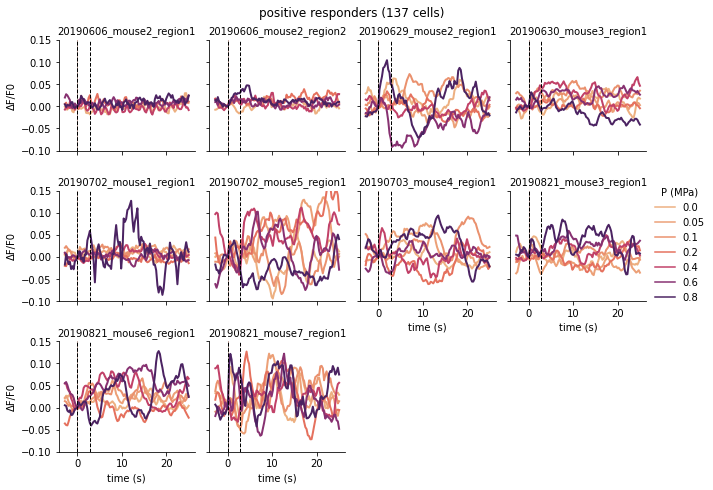

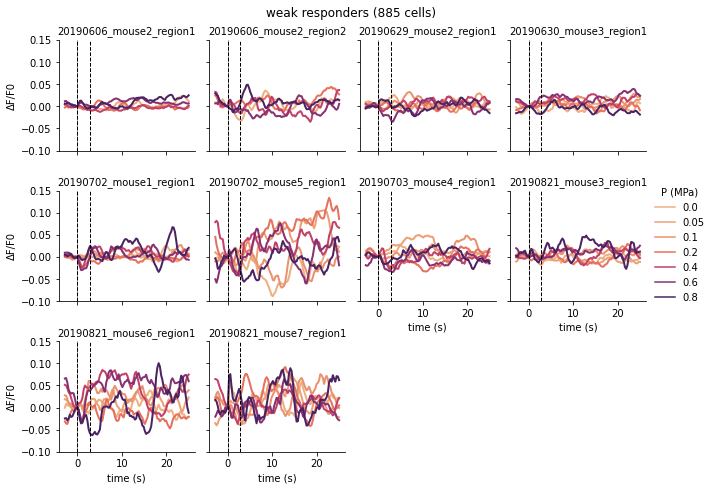

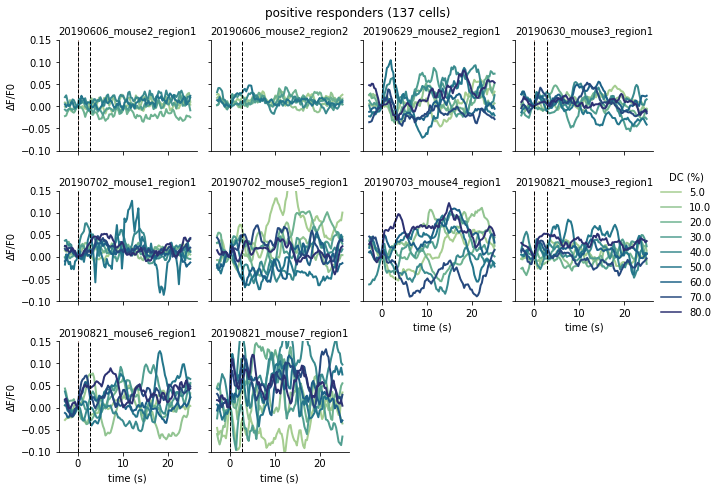

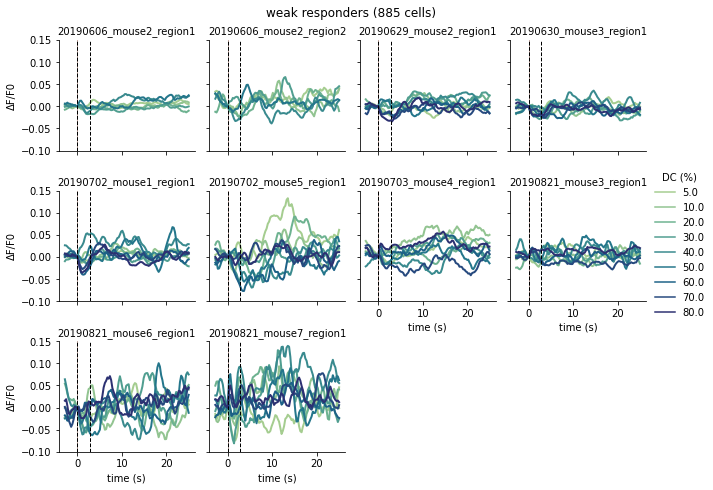

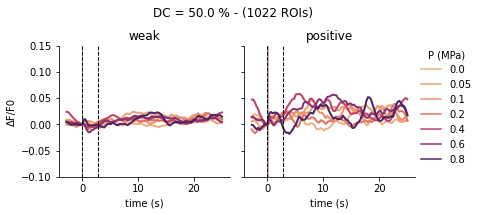

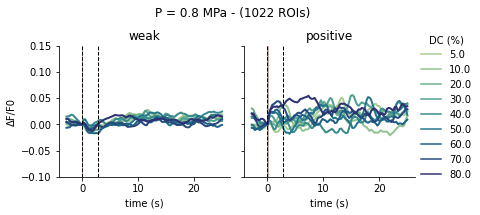

In [9]:
# Get plot-ready traces dataset
plt_data = get_plot_data(timeseries, stats)

# Pressure-dependent response traces, per dataset
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.P))

# DC-dependent response traces, per dataset
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.DC))

# Global (weighted) response curves for both input stimulation parameters  
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type'] = plot_responses_across_datasets(
        plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

In [11]:
plt_data

ΔF/F0  Z(ΔF/F0)  motion  outlier  \
dataset                 ROI run frame                                        
20190606_mouse2_region1 4   0   0     -0.022712 -0.405498     0.0      0.0   
                                1     -0.031948 -0.570391     0.0      0.0   
                                2     -0.017336 -0.309515     0.0      0.0   
                                3     -0.000909 -0.016235     0.0      0.0   
                                4      0.001897  0.033876     0.0      0.0   
...                                         ...       ...     ...      ...   
20190821_mouse7_region1 446 14  95    -0.011070 -0.453945     0.0      0.0   
                                96    -0.004983 -0.204321     0.0      0.0   
                                97    -0.005309 -0.217729     0.0      0.0   
                                98    -0.008550 -0.350623     0.0      0.0   
                                99    -0.026972 -1.106046     0.0      0.0   

                                       pre-stimulus outlier?  event rate (Hz)  \
dataset                 ROI run frame                                           
20190606_mouse2_region1 4   0   0                        0.0         0.000000   
                                1                        0.0         0.000000   
                                2                        0.0         0.000000   
                                3                        0.0         0.000000   
                                4                        0.0         0.101714   
...                                                      ...              ...   
20190821_mouse7_region1 446 14  95                       0.0         0.284800   
                                96                       0.0         0.284800   
                                97                       0.0         0.284800   
                                98                       0.0         0.379733   
                                99                       0.0         0.379733   

                                      line  trial_length  PRF (Hz)  \
dataset                 ROI run frame                                
20190606_mouse2_region1 4   0   0       pv         100.0     100.0   
                                1       pv         100.0     100.0   
                                2       pv         100.0     100.0   
                                3       pv         100.0     100.0   
                                4       pv         100.0     100.0   
...                                    ...           ...       ...   
20190821_mouse7_region1 446 14  95      pv         100.0       NaN   
                                96      pv         100.0       NaN   
                                97      pv         100.0       NaN   
                                98      pv         100.0       NaN   
                                99      pv         100.0       NaN   

                                       duration (s)  ...  \
dataset                 ROI run frame                ...   
20190606_mouse2_region1 4   0   0               0.2  ...   
                                1               0.2  ...   
                                2               0.2  ...   
                                3               0.2  ...   
                                4               0.2  ...   
...                                             ...  ...   
20190821_mouse7_region1 446 14  95              0.2  ...   
                                96              0.2  ...   
                                97              0.2  ...   
                                98              0.2  ...   
                                99              0.2  ...   

                                       post-stim avg ΔF/F0 - pre-stim avg ΔF/F0 tstat  \
dataset                 ROI run frame                                                   
20190606_mouse2_region1 4   0   0                                           -5.605687   
              

 25/10/2022 15:18:57: plotting P (MPa) dependency curves for positive responders...
 25/10/2022 15:18:57: sub-indexing data...
 25/10/2022 15:18:57: filtering data...
 25/10/2022 15:18:57: cross-checking filters...
 25/10/2022 15:18:57: grouping by dataset, grouping by P (MPa), averaging and plotting mean event rate (Hz) vs. time (s) ...
 25/10/2022 15:18:59: plotting P (MPa) dependency curves for weak responders...
 25/10/2022 15:19:00: sub-indexing data...
 25/10/2022 15:19:00: filtering data...
 25/10/2022 15:19:03: cross-checking filters...
 25/10/2022 15:19:05: grouping by dataset, grouping by P (MPa), averaging and plotting mean event rate (Hz) vs. time (s) ...
 25/10/2022 15:19:11: plotting DC (%) dependency curves for positive responders...
 25/10/2022 15:19:11: sub-indexing data...
 25/10/2022 15:19:11: filtering data...
 25/10/2022 15:19:11: cross-checking filters...
 25/10/2022 15:19:11: grouping by dataset, grouping by DC (%), averaging and plotting mean event rate (Hz) vs.

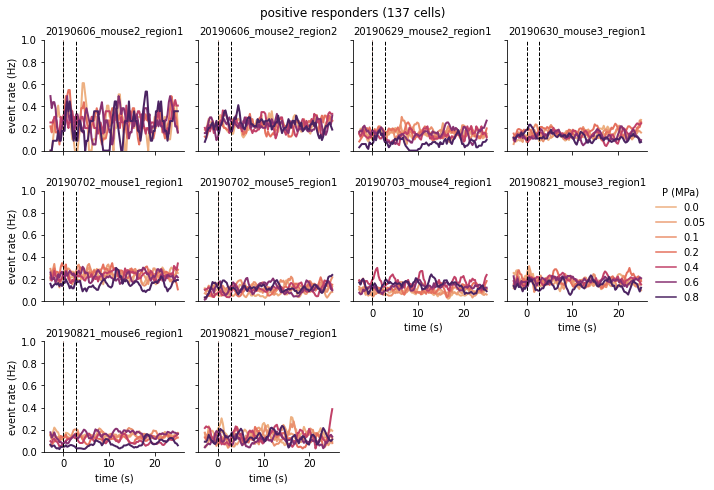

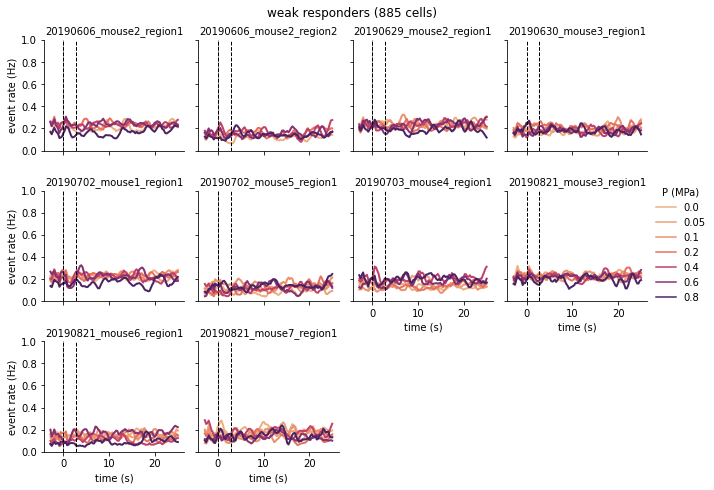

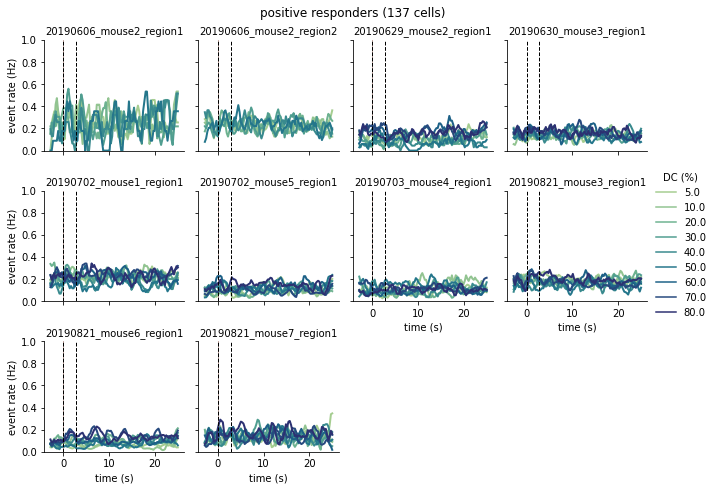

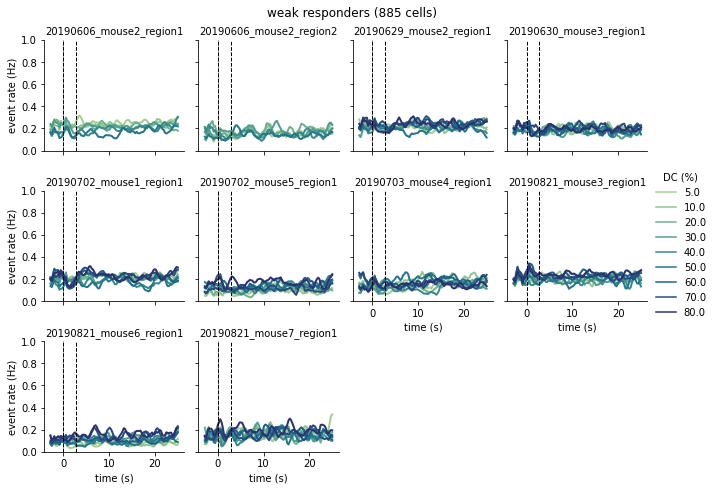

In [13]:
# Pressure-dependent response traces, per dataset
figs.update(
    plot_responses_across_datasets(plt_data, ykey=Label.EVENT_RATE, pkey=Label.P))
# Pressure-dependent response traces, per dataset
figs.update(
    plot_responses_across_datasets(plt_data, ykey=Label.EVENT_RATE, pkey=Label.DC))

### Save figures

In [10]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 07/10/2022 20:26:49: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.10.07/figs_sst_k0.5_w10.0s_q0.08_smooth_ΔFF0.pdf:


100%|██████████| 12/12 [00:02<00:00,  4.40it/s]


### Notify upon completion

In [11]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 07/10/2022 20:26:52: sst batch notebook completed in 0:00:58.528200 s
